<a href="https://colab.research.google.com/github/nps1984/DSC680/blob/main/image-captioning/image_captioning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import string
import numpy as np
import os
import pandas as pd

from collections import Counter
from google.colab import drive
from keras.applications.xception import Xception, preprocess_input
from keras.layers.merge import add
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path, PurePath
from pickle import dump, load
from tqdm.notebook import tqdm


In [ ]:
# To see loop status, get a future warning
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# mount my google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### SOURCE ####
# Drive Path
DRIVE_PATH=PurePath('/content/drive/MyDrive/data/image-captioning/')

# Zip files
SRC_IMAGE_ZIP_FILE=PurePath(DRIVE_PATH,'Flickr8k_Dataset.zip')
SRC_TEXT_ZIP_FILE=PurePath(DRIVE_PATH,'Flickr8k_text.zip')

# Glove file
SRC_GLOVE_FILE=PurePath(DRIVE_PATH,'glove.6B.200d.txt')
#### TARGET ####
### Local Colab instance paths
ROOT_PATH=PurePath('/content')

### PATHS ###
PROJECT_PATH=PurePath(ROOT_PATH,'image-captioning')

# Unzip Paths
IMG_PARENT_PATH=PurePath(PROJECT_PATH,'Flickr8k_Dataset')
TEXT_PARENT_PATH=PurePath(PROJECT_PATH,'Flickr8k_text')

# Glove path
GLOVE_PATH=PurePath(PROJECT_PATH,'glove')

# Unzipped images
IMG_PATH=PurePath(IMG_PARENT_PATH,'Flicker8k_Dataset')

# Pickles
PICKLE_PATH=PurePath(PROJECT_PATH,'pickles')

# Models
MODELS_PATH=PurePath(PROJECT_PATH,'models')

# Model Weights
WEIGHTS_PATH=PurePath(PROJECT_PATH,'weights')

#### FILES #####
# Target Zips
TGT_IMAGE_ZIP_FILE=PurePath(PROJECT_PATH,'Flickr8k_Dataset.zip')
TGT_TEXT_ZIP_FILE=PurePath(PROJECT_PATH,'Flickr8k_text.zip')

# Target Glove
GLOVE_FILE=PurePath(GLOVE_PATH,'glove.6B.200d.txt')

# Training text
TOKEN_TEXT=PurePath(TEXT_PARENT_PATH,'Flickr8k.token.txt')
TRAIN_TEXT=PurePath(TEXT_PARENT_PATH,'Flickr_8k.trainImages.txt')
TEST_TEXT=PurePath(TEXT_PARENT_PATH,'Flickr_8k.testImages.txt')
VAL_TEXT=PurePath(TEXT_PARENT_PATH,'Flickr_8k.devImages.txt')

# Descriptions output file
DESCRIPTION_FILE=PurePath(TEXT_PARENT_PATH,'description.txt')

# Pickle files
FEATURES_PICKLE=PurePath(PICKLE_PATH,'features.p')
TOKENIZER_PICKLE=PurePath(PICKLE_PATH,'tokenizer.p')
TRAIN_PICKLE=PurePath(PICKLE_PATH,'encoded_train_images.pkl')
TEST_PICKLE=PurePath(PICKLE_PATH,'encoded_test_images.pkl')


In [ ]:
# make my paths
!mkdir -p "$PROJECT_PATH"
!mkdir -p "$IMG_PARENT_PATH"
!mkdir -p "$TEXT_PARENT_PATH"
!mkdir -p "$IMG_PATH"
!mkdir -p "$PICKLE_PATH"
!mkdir -p "$MODELS_PATH"
!mkdir -p "$WEIGHTS_PATH"
!mkdir -p "$GLOVE_PATH"

In [ ]:
# Copy the files from my google drive to local vm
!cp "$SRC_IMAGE_ZIP_FILE" "$TGT_IMAGE_ZIP_FILE"
!cp "$SRC_TEXT_ZIP_FILE" "$TGT_TEXT_ZIP_FILE"
!cp "$SRC_GLOVE_FILE" "$GLOVE_FILE"

In [ ]:
# unzip the dataset
!unzip -q "$TGT_IMAGE_ZIP_FILE" -d "$IMG_PARENT_PATH"
!unzip -q "$TGT_TEXT_ZIP_FILE" -d "$TEXT_PARENT_PATH"

In [ ]:
# Loading a text file into memory
def load_doc(filename):
  # Opening the file as read only
  file = open(filename, 'r')
    
  # read the file
  text = file.read()

  # close the file
  file.close()

  # return the text
  return text


In [ ]:
# get all imgs with their captions
def all_img_captions(filename):
  file = load_doc(filename)
  captions = file.split('\n')
  descriptions ={}
  
  for caption in captions[:-1]:
    img, caption = caption.split('\t')
    if img[:-2] not in descriptions:
      descriptions[img[:-2]] = [ caption ]
    else:
      descriptions[img[:-2]].append(caption)
  return descriptions



In [ ]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
  table = str.maketrans('','',string.punctuation)
  
  for img,caps in captions.items():
    for i,img_caption in enumerate(caps):

      img_caption.replace("-"," ")
      desc = img_caption.split()

      #converts to lowercase
      desc = [word.lower() for word in desc]
      
      #remove punctuation from each token
      desc = [word.translate(table) for word in desc]
      
      #remove hanging 's and a 
      desc = [word for word in desc if(len(word)>1)]
      
      #remove tokens with numbers in them
      desc = [word for word in desc if(word.isalpha())]
      
      #convert back to string
      img_caption = ' '.join(desc)
      captions[img][i]= img_caption

  return captions



In [ ]:
def text_vocabulary(descriptions):
  # build vocabulary of all unique words
  vocab = set()

  for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]

  return vocab



In [ ]:
def get_features(directory):
  model = Xception( include_top=False, pooling='avg' )
  features = {}
  
  for img in tqdm(os.listdir(directory)):
    filename = PurePath(directory,img).__str__()
    image = Image.open(filename)
    image = image.resize((299,299))
    image = np.expand_dims(image, axis=0)
    #image = preprocess_input(image)
    image = image/127.5
    image = image - 1.0

    feature = model.predict(image)
    features[img] = feature
  return features

In [ ]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + '\t' + desc )
  data = "\n".join(lines)
  file = open(filename,"w")
  file.write(data)
  file.close()

In [ ]:
#load the data 
def load_photos(filename):
  file = load_doc(filename)
  photos = file.split("\n")[:-1]
  return photos


In [ ]:
def load_clean_descriptions(filename, photos): 
  #loading clean_descriptions
  file = load_doc(filename)

  descriptions = {}
  for line in file.split("\n"):
    words = line.split()
    if len(words)<1 :
      continue

    image, image_caption = words[0], words[1:]

    if image in photos:
      if image not in descriptions:
        descriptions[image] = []
      desc = '<start> ' + " ".join(image_caption) + ' <end>'
      descriptions[image].append(desc)

  return descriptions


In [ ]:
def load_features(photos, feat_pick):
  #loading all features
  all_features = load(open(feat_pick,"rb"))

  #selecting only needed features
  features = {k:all_features[k] for k in photos}
  
  return features

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc



In [ ]:
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
def create_tokenizer(descriptions):
  desc_list = dict_to_list(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(desc_list)
  return tokenizer


In [ ]:
#calculate maximum length of descriptions
def max_length(descriptions):
  desc_list = dict_to_list(descriptions)
  return max(len(d.split()) for d in desc_list)
    

In [ ]:
def create_sequences(tokenizer, max_length, desc_list, feature):
  X1, X2, y = list(), list(), list()
  # walk through each description for the image
  for desc in desc_list:
    # encode the sequence
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
      # split into input and output pair
      in_seq, out_seq = seq[:i], seq[i]
      # pad input sequence
      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
      # encode output sequence
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      # store
      X1.append(feature)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1), np.array(X2), np.array(y)

In [ ]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
      #retrieve photo features
      feature = features[key][0]
      input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
      yield ([input_image, input_sequence], output_word)


In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):

  # features from the CNN model squeezed from 2048 to 256 nodes
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)

  # LSTM sequence model
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)

  # Merging both models
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')

  # summarize model
  print(model.summary())
  plot_model(model, to_file='model.png', show_shapes=True)

  return model

In [ ]:
def extract_features(filename, model):
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
  
  image = image.resize((299,299))
  image = np.array(image)
  
  # for images that has 4 channels, we convert them into 3 channels
  if image.shape[2] == 4: 
    image = image[..., :3]
  
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  image = image - 1.0
  
  feature = model.predict(image)
  
  return feature

In [ ]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  
  return None



In [ ]:
def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    pred = model.predict([photo,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
      break
    in_text += ' ' + word
    if word == 'end':
      break
  return in_text



# EDA

In [ ]:
# Grab our jpegs
jpgs = os.listdir(IMG_PATH)
print(f"The number of jpg flies in Flicker8k: {len(jpgs)}")

The number of jpg flies in Flicker8k: 8091


In [ ]:
# Read our token text file
file = open(TOKEN_TEXT,'r')
text = file.read()
file.close()

In [ ]:
# Grab 
text_list = []

# split the text file on newlines, and loop
for line in text.split('\n'):
  # split each line on tabs, skip lines that don't have info
  col = line.split('\t')
  if len(col) == 1:
    continue
  
  # split first column on hashtag
  w = col[0].split("#")

  # append to our list
  text_list.append(w + [col[1].lower()])

# create dataframe of image name, caption index, and actual caption
df_txt = pd.DataFrame(text_list,columns=["filename","index","caption"])

# Get number of unique files and print info
uni_filenames = np.unique(df_txt.filename.values)
print(f"The number of unique file names : {len(uni_filenames)}")
print(f"The distribution of the number of captions for each image:{Counter(Counter(df_txt.filename.values).values())}")


The number of unique file names : 8092
The distribution of the number of captions for each image:Counter({5: 8092})


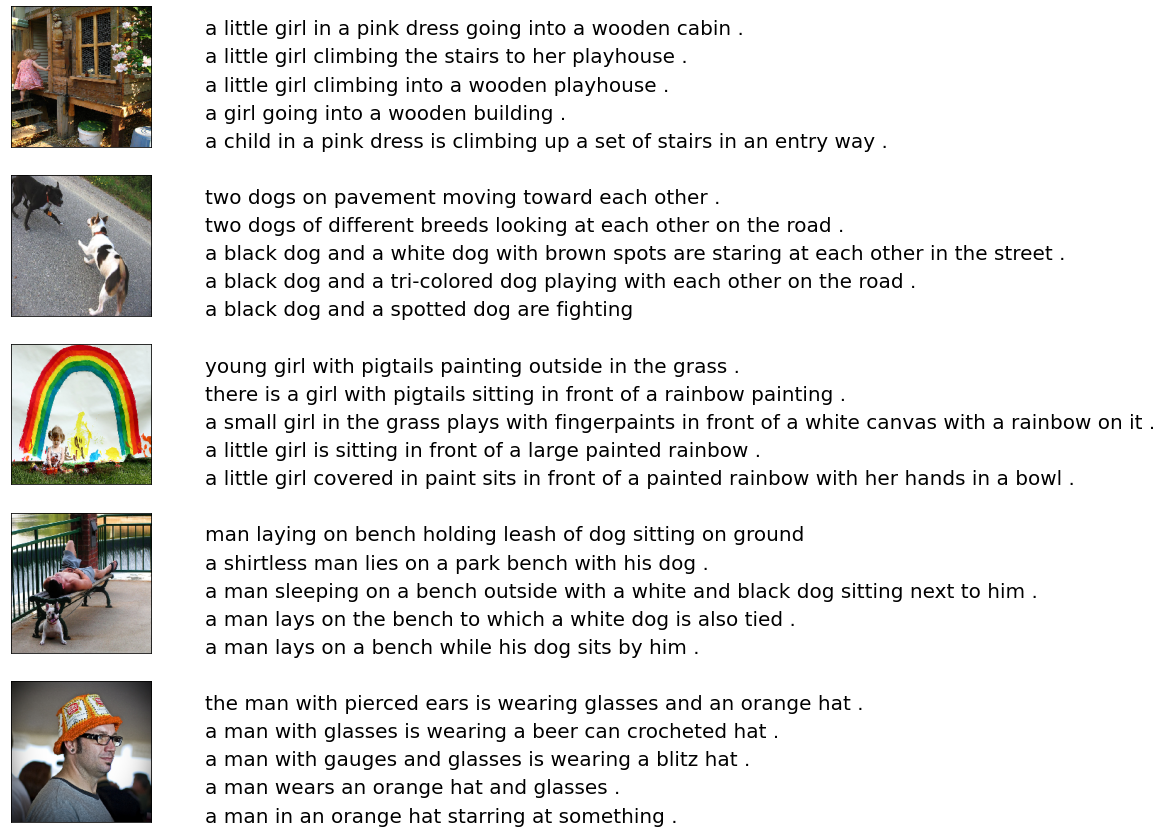

In [ ]:
# EDA
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(7,15))

# Get file name from our list of unique filenames, and print image and captions
for jpgfnm in uni_filenames[:npic]:
  # get file location
  filename = PurePath(IMG_PATH, jpgfnm)

  # Get our captions
  captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
  image_load = load_img(filename, target_size=target_size)

  # do some plotting  
  ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
  ax.imshow(image_load)
  count += 1
    
  ax = fig.add_subplot(npic,2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(captions))
  for i, caption in enumerate(captions):
      ax.text(0,i,caption,fontsize=20)
  count += 1

plt.show()

In [ ]:
# built a rough vocab and get some word info
vocabulary = []

for txt in df_txt.caption.values:
  vocabulary.extend(txt.split())

ct = Counter(vocabulary)
dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
dfword = dfword.sort_values("count",ascending=False)
dfword = dfword.reset_index()[["word","count"]]

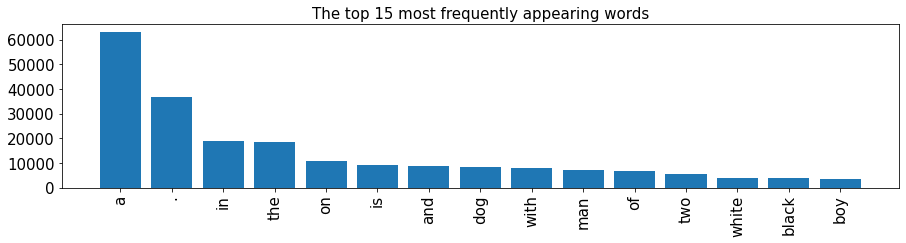

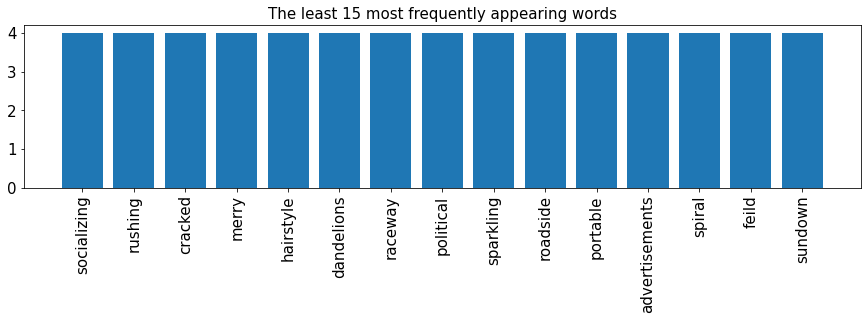

In [ ]:
topn = 15

def plthist(dfsub, title="The top 15 most frequently appearing words"):
    plt.figure(figsize=(15,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=15)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 15 most frequently appearing words")
# lets get words that appear a few times just to minimize misspellings
plthist(dfword[dfword['count']>3].iloc[-topn:,:],
        title="The least 15 most frequently appearing words")

In [ ]:
df_txt['cleaned_caption'] = df_txt['caption'].str.replace(r'[^\w\s]+', '')
print(f"Caption as is avg len: {df_txt['caption'].apply(len).mean()}")
print(f"Caption rough clean avg len: {df_txt['cleaned_caption'].apply(len).mean()}")

Caption as is avg len: 55.1327731092437
Caption rough clean avg len: 54.102595155709345


In [ ]:
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(TOKEN_TEXT)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, DESCRIPTION_FILE)

Length of descriptions = 8092
Length of vocabulary =  8763


In [ ]:
#2048 feature vector
features = get_features(IMG_PATH)
dump(features, open(FEATURES_PICKLE,"wb"))

In [ ]:
len(features)

8091

In [ ]:
# read it back in
features = load(open(FEATURES_PICKLE,"rb"))


In [ ]:
# load up my training images
train_imgs = load_photos(TRAIN_TEXT)
val_imgs = load_photos(VAL_TEXT)
test_imgs = load_photos(TEST_TEXT)

# get descriptions for my training images
train_descriptions = load_clean_descriptions(DESCRIPTION_FILE, train_imgs)
val_descriptions = load_clean_descriptions(DESCRIPTION_FILE, val_imgs)
test_descriptions = load_clean_descriptions(DESCRIPTION_FILE, test_imgs)

# get image freatures 
train_features = load_features(train_imgs, FEATURES_PICKLE)
val_features = load_features(val_imgs, FEATURES_PICKLE)
test_features = load_features(test_imgs, FEATURES_PICKLE)

In [ ]:
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open(TOKENIZER_PICKLE, 'wb'))

In [ ]:
# get size of vocab from tokenizer
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [ ]:
max_length = max_length(train_descriptions)
max_length

34

In [ ]:
#create input-output sequence pairs from the image description.
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 34), (47, 7577))

In [ ]:
# print info
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  34


In [ ]:
# define the model
model = define_model(vocab_size, max_length)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1939712     input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_3[0][0]                    
______________________________________________________________________________________________

In [ ]:
# train our model
epochs = 10
#steps = len(train_descriptions)

number_pics_per_batch = 3
train_steps = len(train_descriptions)//number_pics_per_batch
val_steps = len(val_descriptions)//number_pics_per_batch
train_generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
val_generator = data_generator(val_descriptions, val_features, tokenizer, max_length)
test_generator = data_generator(test_descriptions, test_features, tokenizer, max_length)


In [ ]:
history = model.fit(train_generator, steps_per_epoch=train_steps, 
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    epochs=epochs,
                    use_multiprocessing=True,
                   workers=16,
                   max_queue_size=32)

Epoch 1/10
2000/2000 [==============================] - 234s 115ms/step - loss: 4.2774 - val_loss: 7.0188
Epoch 2/10
2000/2000 [==============================] - 228s 114ms/step - loss: 3.4523 - val_loss: 6.3222
Epoch 3/10
2000/2000 [==============================] - 230s 115ms/step - loss: 3.3966 - val_loss: 6.3295
Epoch 4/10
2000/2000 [==============================] - 232s 116ms/step - loss: 3.6102 - val_loss: 6.6426
Epoch 5/10
2000/2000 [==============================] - 233s 116ms/step - loss: 3.3469 - val_loss: 5.7040
Epoch 6/10
2000/2000 [==============================] - 232s 116ms/step - loss: 3.8407 - val_loss: 6.3438
Epoch 7/10
2000/2000 [==============================] - 236s 118ms/step - loss: 3.5785 - val_loss: 6.4503
Epoch 8/10
2000/2000 [==============================] - 234s 117ms/step - loss: 3.8549 - val_loss: 5.9333
Epoch 9/10
2000/2000 [==============================] - 239s 120ms/step - loss: 3.4739 - val_loss: 6.1004
Epoch 10/10
2000/2000 [=======================

In [ ]:
model.metrics_names

['loss']

In [ ]:
val_loss = \
model.evaluate(test_generator,  steps=len(val_descriptions))

print('val_loss:', val_loss)

1000/1000 [==============================] - 12s 12ms/step - loss: 5.9610
val_loss: 5.960994720458984


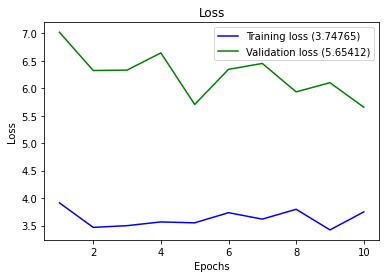

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
plot_history(history)

In [ ]:
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
#for i in range(epochs):
#    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
#    model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
#    model.save(f"{MODELS_PATH}/model_" + str(i) + ".h5")

6000/6000 [==============================] - 663s 110ms/step - loss: 2.7887


In [ ]:
print

/content/image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/111537222_07e56d5a30.jpg



start man is climbing rock blue snowy slide end


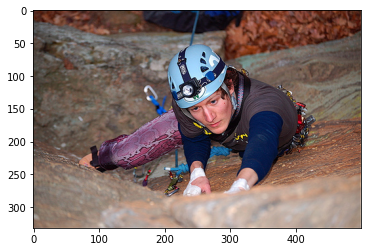

In [ ]:
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=True, help="Image Path")
args = vars(ap.parse_args(['--image', f'{IMG_PATH}/111537222_07e56d5a30.jpg']))
img_path = args['image']

print(img_path)

#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 34
tokenizer = load(open(TOKENIZER_PICKLE,"rb"))
#model = load_model(f"{MODELS_PATH}/model_9.h5")
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)